```@meta
CurrentModule = AlgorithmicRecourse 
```

In [1]:
using Flux
using Random
using Plots
using PlotThemes
theme(:juno)
using Logging
disable_logging(Logging.Info)

LogLevel(1)

# Generating recourse

To understand the core functionality of AlgorithmicRecourse.jl we will look at two example use cases of the `generate_recourse` function. This function takes a structure of type `Generator` as its main argument. Users can utilize one of the [default generators](#default-generators): `GenericGenerator <: Generator`, `GreedyGenerator <: Generator`. Alternatively, users can also create their own [custom generator](#custom-generators). 

```@docs
generate_recourse(generator::Generator, x̅::AbstractArray, 𝑴::Models.FittedModel, target::Float64, γ::Float64; T=1000)
```

## Default generators

### `GenericGenerator`

Let $t\in\{0,1\}$ denote the target label, $M$ the model (classifier) and $\underline{x}\in\mathbb{R}^D$ the vector of counterfactual features. In order to generate recourse the `GenericGenerator` optimizes the following objective function through steepest descent

```math
\underline{x} = \arg \min_{\underline{x}}  \ell(M(\underline{x}),t) + \lambda h(\underline{x})
```

where $\ell$ denotes some loss function targeting the deviation between the target label and the predicted label and $h(\cdot)$ as a complexity penality generally addressing the *realism* or *cost* of the proposed counterfactual. 

Let's generate some toy data:

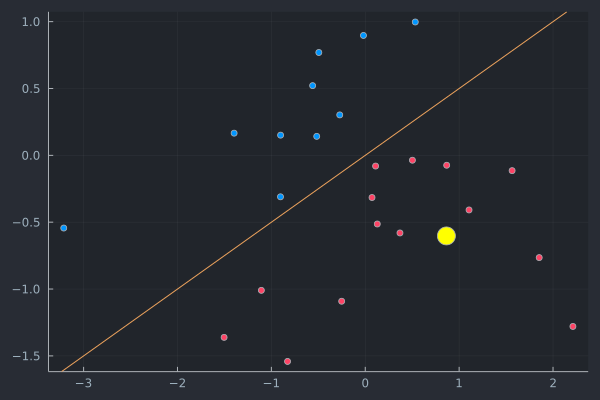

In [2]:
# Some random data:
Random.seed!(1234);
N = 25
w = reshape([1.0,-2.0],2,1) # true coefficients
b = 0
X = reshape(randn(2*N),N,2).*1 # random features
y = Int.(round.(Flux.σ.(X*w .+ b))); # label based on sigmoid
# Choose sample and plot:
x̅ = reshape(X[5,:],1,2)
scatter(X[:,1],X[:,2],legend=false,color=y) # features
Plots.abline!(-w[1]/w[2],0) # decision boundary
scatter!([x̅[1]],[x̅[2]],color="yellow",markersize=10)

For this toy data we will now implement algorithmic recourse as follows:

- Use the coefficients `w` and `b` to define our model using `AlgorithmicRecourse.Models.LogisticModel(w, b)`.
- Define our `GenericGenerator`.
- Generate recourse.

In [3]:
using AlgorithmicRecourse
𝑴 = AlgorithmicRecourse.Models.LogisticModel(w, [b]);
y̅ = round.(AlgorithmicRecourse.Models.probs(𝑴, x̅))[1]
target = ifelse(y̅==1.0,0.0,1.0)
γ = ifelse(target==1.0,0.75,0.25)
generator = GenericGenerator(0.1,0.1,1e-5,:logitbinarycrossentropy,nothing)
recourse = generate_recourse(generator, x̅, 𝑴, target, γ); # generate recourse

Finally, let's plot the resulting counterfactual path:

Plots.AnimatedGif("/var/folders/99/2fj_h1qs3gj3x8nqmpx20mrc0000gq/T/jl_VvcEiH.gif")
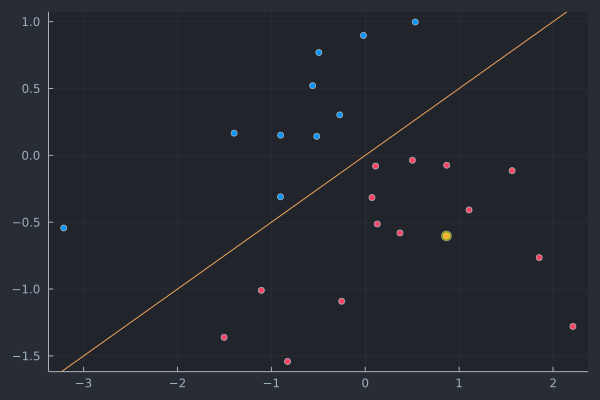

In [4]:
scatter(X[:,1],X[:,2],legend=false,color=y) # features
Plots.abline!(-w[1]/w[2],0) # decision boundary
T = size(recourse.path)[1]
anim = @animate for t in 1:T
    scatter!([recourse.path[t,1]], [recourse.path[t,2]], color="yellow", markersize=5+t, alpha = 0.5 + 0.5*t/T)
end
gif(anim, fps=5)

### `GreedyGenerator`

Next we will repeat the exercise above, but instead use the `GreedyGenerator` in the context of a Bayesian classifier. This generator is greedy in the sense that it simply chooses the most salient feature $\underline{x}[d]$ where $d=\arg\max_{d \in [1,D]} \nabla_{\underline{x}} \ell(M(\underline{x}),t)$ and perturbs it by a fixed amount $\delta$. In other words, optimization is penalty-free. This is possible in the Bayesian context, because maximizing the predictive probability $\gamma$ corresponds to minimizing the predictive uncertainty: by construction the generated counterfactual will therefore be *realistic* (low epistemic uncertainty) and *unambiguous* (low aleotoric uncertainty).

In [5]:
using LinearAlgebra
Σ = Symmetric(reshape(randn(9),3,3).*0.05 + UniformScaling(0.5)) # MAP covariance matrix
μ = vcat(b, w)
𝑴 = AlgorithmicRecourse.Models.BayesianLogisticModel(μ, Σ);
generator = GreedyGenerator(0.1,5,:logitbinarycrossentropy,nothing)
recourse = generate_recourse(generator, x̅, 𝑴, target, γ); # generate recourse

In [6]:
recourse.path

1000×2 Matrix{Float64}:
 0.864401  -0.602707
 0.864401  -0.502707
 0.864401  -0.402707
 0.864401  -0.302707
 0.864401  -0.202707
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707
 ⋮         
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707
 0.864401  -0.102707

Plots.AnimatedGif("/var/folders/99/2fj_h1qs3gj3x8nqmpx20mrc0000gq/T/jl_JFd7TK.gif")
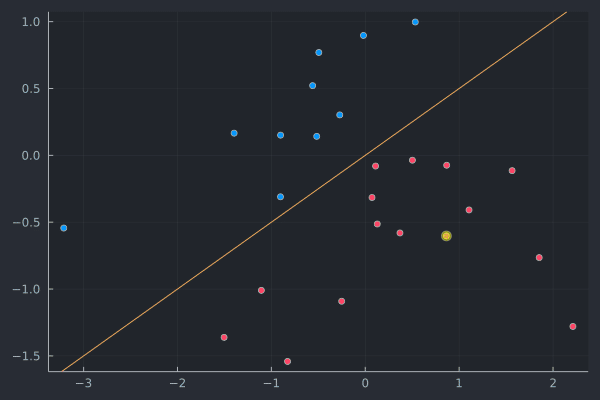

In [7]:
scatter(X[:,1],X[:,2],legend=false,color=y) # features
Plots.abline!(-w[1]/w[2],0) # decision boundary
T = size(recourse.path)[1]
anim = @animate for t in 1:T
    scatter!([recourse.path[t,1]], [recourse.path[t,2]], color="yellow", markersize=5+t, alpha = 0.5 + 0.5*t/T)
end
gif(anim, fps=5)